## **Building A Speech Recognition Model with TensorFlow**

1. preprocess audio files in the WAV format
You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".
2. Build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words.


### Install tensorflow datasets & cuDNN library for CUDA

In [1]:
## install the cuda GPUs
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 13 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,027 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 11s (38.6 MB/s)
(Reading database ... 123069 files and directories currently installed.)
Removing libcudnn8-dev (8.9.0.131-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.9.0.131-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 123036 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.

In [2]:
!pip install -U -q tensorflow tensorflow_datasets

In [3]:
## allow interaction with the operating system
import pathlib

In [4]:
## import machine learning modules
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
## import the modules for deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Resizing, Normalization

In [6]:
## import 'display' for displaying images, videos, HTML, and other media
from IPython import display
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
## import a small version "Speech Commands" dataset
DATASET_PATH = 'data/mini_speech_commands'

In [8]:
## download and extract a dataset, unzip the file and store in cache_directory
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


The dataset's audio clips are stored in eight folders corresponding to each speech command:
- '**no**', '**yes**', '**down**', '**go**', '**left**', '**up**', '**right**', & '**stop**'

In [9]:
## list the contents of a directory & filter unwanted files, such as 'README.md' & '.DS_Store'
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['left' 'yes' 'up' 'right' 'stop' 'down' 'go' 'no']


In [10]:
## split the file into the train and validation dataset
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [11]:
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio

---

clips have a shape of `(batch, samples, channels)`.

In [12]:
## obtain the training
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
## define a function to automatically determine the optimal number of parallel calls to use during the mapping
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

In [14]:
## apply the function to the training data to map every element of the dataset
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [15]:
## apply to test data
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [16]:
## the result of the squeeze
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [17]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

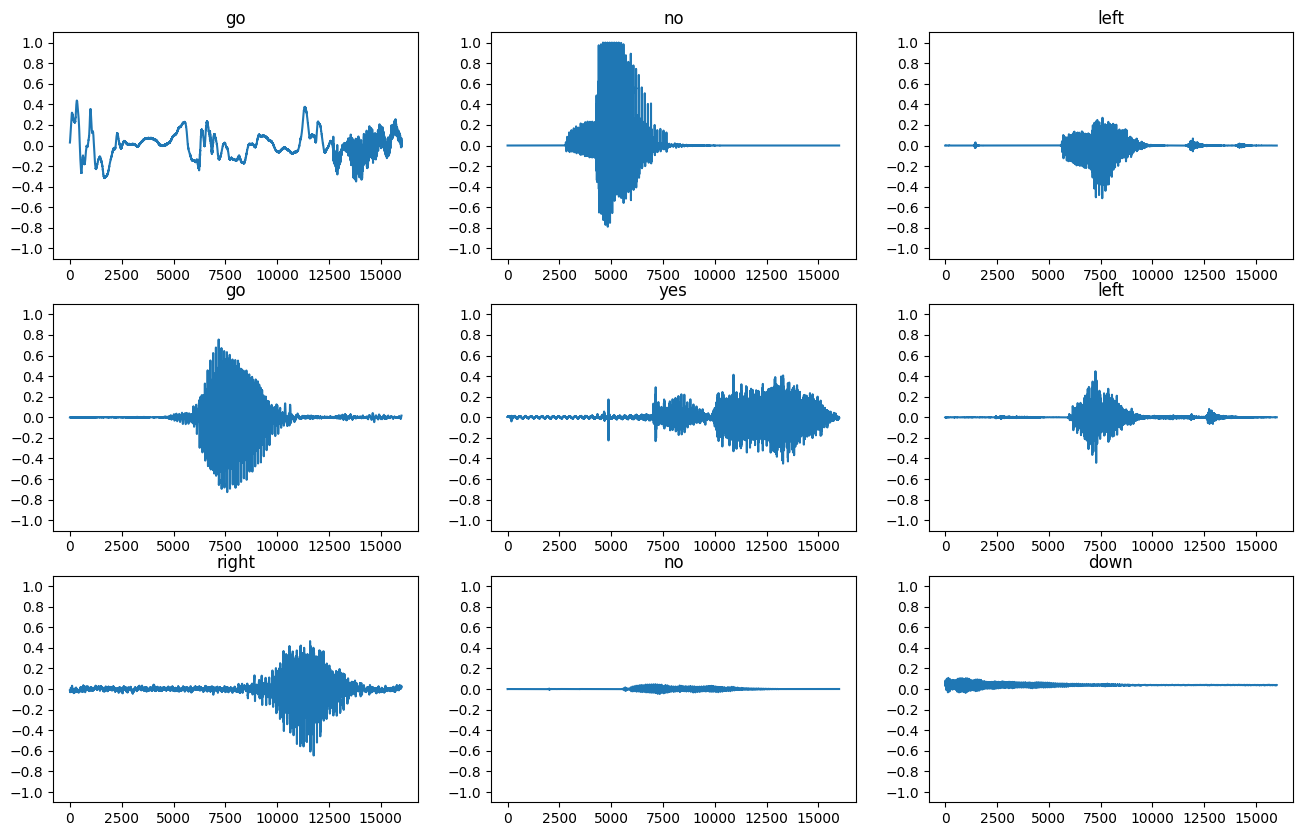

In [18]:
## generate a plot of the waveforms
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

### Convert waveforms to spectrograms into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)]

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the have similar dimensions; using `tf.zeros`.
- Choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square (when calling `tf.signal.stft`)
- The STFT produces an array of complex numbers representing magnitude & phase, select the magnitue by applying `tf.abs` on the output of `tf.signal.stft`.

In [19]:
## convert waveforms to spectrogrms
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [20]:
## print out the waveforms
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [21]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

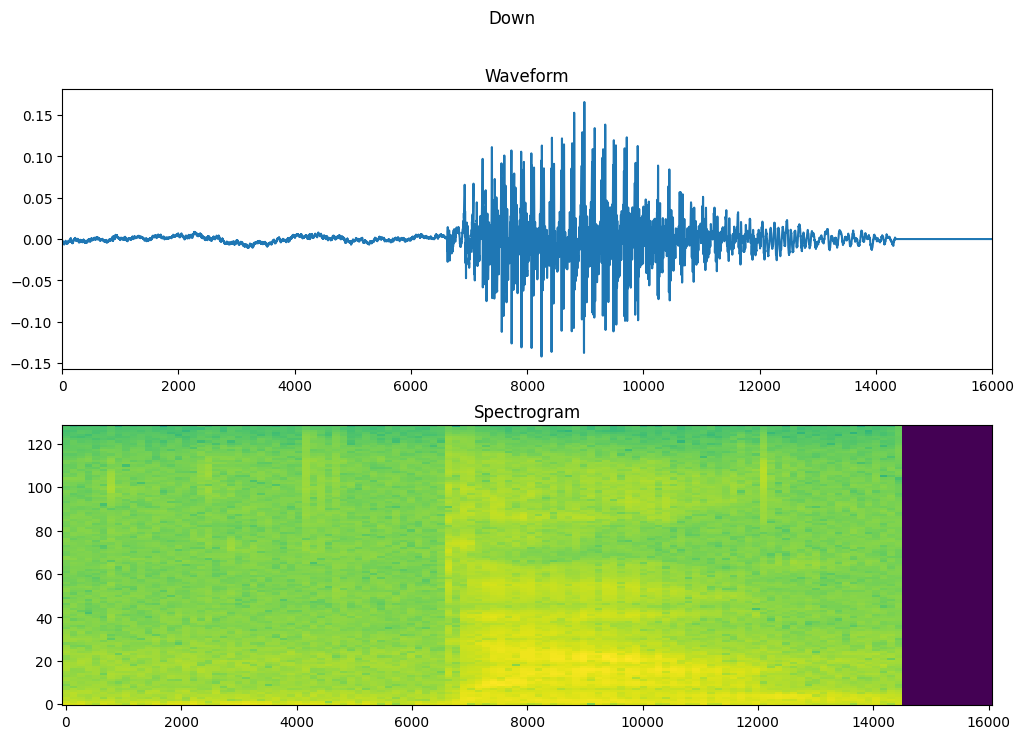

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [23]:
## function to create a spectrogram of each image
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
## apply to the train and train, test, and validation datasets
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [25]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

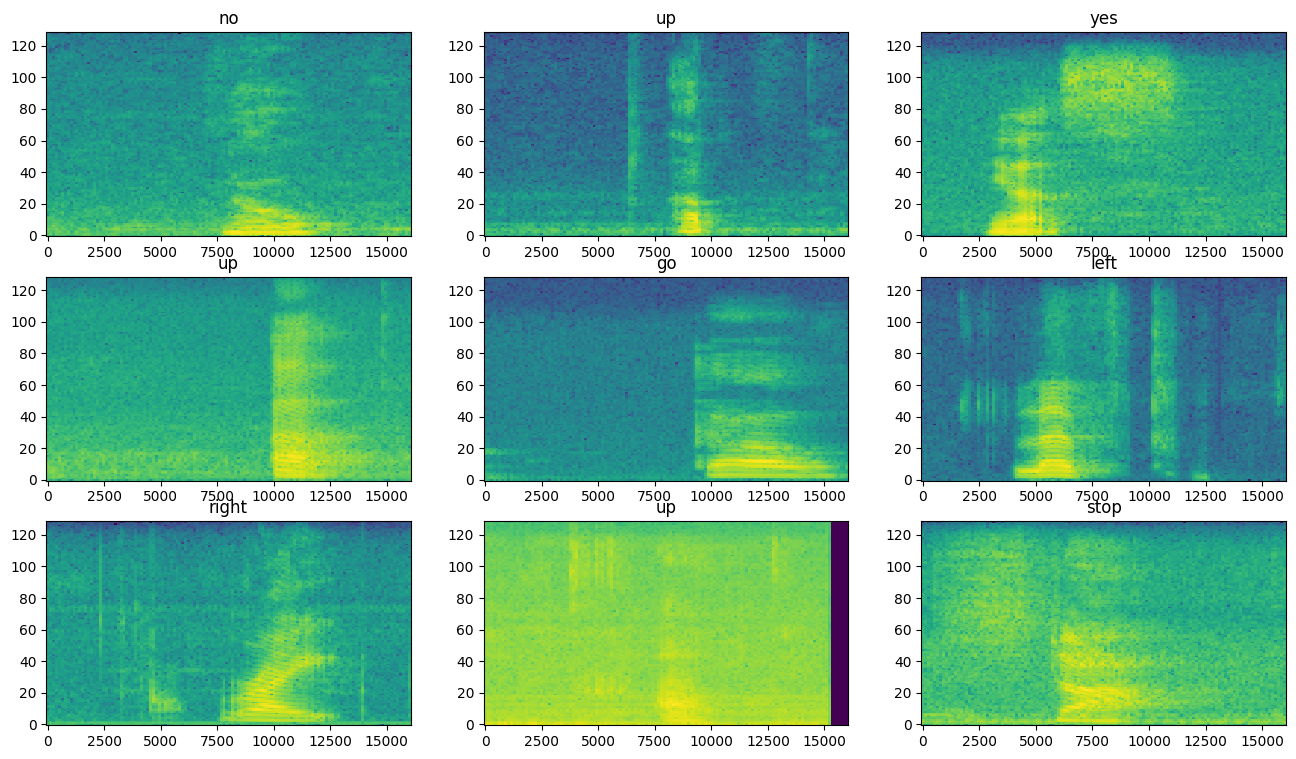

In [26]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [27]:
## add the ds.cache and ds.prefetch to speed up the model fitting/training
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [28]:
## create the input shape for each file
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


In [29]:
## instantiate the `tf.keras.layers.Normalization` layer
norm_layer = Normalization()
# fit the state of the layer to the spectrograms with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [30]:
## define the neural network model
model = Sequential([
    Input(shape=input_shape),
    # Downsample the input.
    Resizing(32, 32),
    # Normalize.
    norm_layer,
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_labels),
])

In [31]:
## view the models parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [32]:
## compile the NN model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [33]:
## train the model
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 29s 276ms/step - loss: 1.7468 - accuracy: 0.3659 - val_loss: 1.3763 - val_accuracy: 0.5742
Epoch 2/10
100/100 [==============================] - 25s 253ms/step - loss: 1.2009 - accuracy: 0.5739 - val_loss: 0.9499 - val_accuracy: 0.7135
Epoch 3/10
100/100 [==============================] - 27s 268ms/step - loss: 0.9085 - accuracy: 0.6777 - val_loss: 0.7731 - val_accuracy: 0.7539
Epoch 4/10
100/100 [==============================] - 27s 271ms/step - loss: 0.7515 - accuracy: 0.7387 - val_loss: 0.6884 - val_accuracy: 0.7721
Epoch 5/10
100/100 [==============================] - 25s 252ms/step - loss: 0.6498 - accuracy: 0.7706 - val_loss: 0.6306 - val_accuracy: 0.8073
Epoch 6/10
100/100 [==============================] - 26s 256ms/step - loss: 0.5437 - accuracy: 0.8025 - val_loss: 0.5864 - val_accuracy: 0.8099
Epoch 7/10
100/100 [==============================] - 25s 253ms/step - loss: 0.4748 - accuracy: 0.8327 - val_loss: 0.5064 - val_ac

Text(0, 0.5, 'Accuracy [%]')

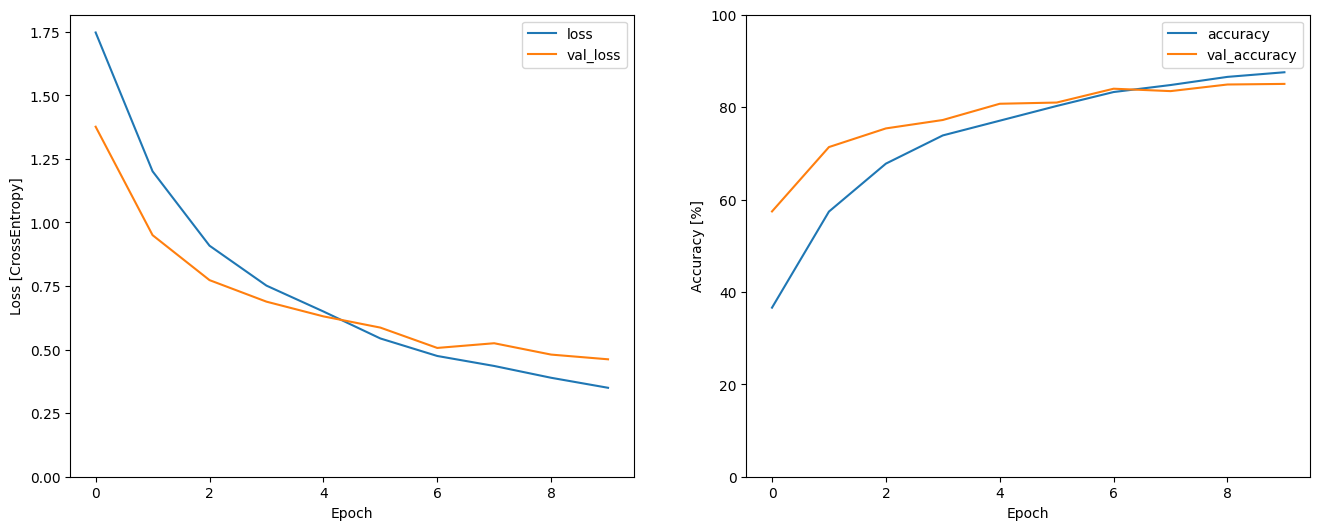

In [34]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [35]:
## evaluate the performance of the model
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 4s 236ms/step - loss: 0.4546 - accuracy: 0.8522


{'loss': 0.4545845687389374, 'accuracy': 0.8521634340286255}

In [36]:
## generate predictions using the test data
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 51ms/step


In [37]:
## obtain the index for the predictions
y_pred = tf.argmax(y_pred, axis=1)

In [38]:
## combine the evaluations
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

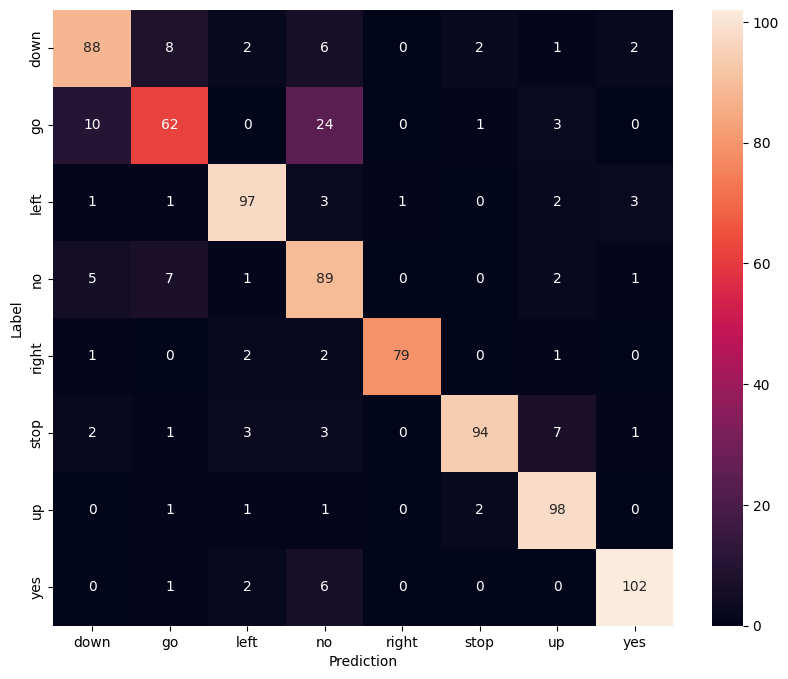

In [39]:
## generate the confusion matrix to evaluate the model's performance
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Verify the model's prediction output using an input audio file with a "no"

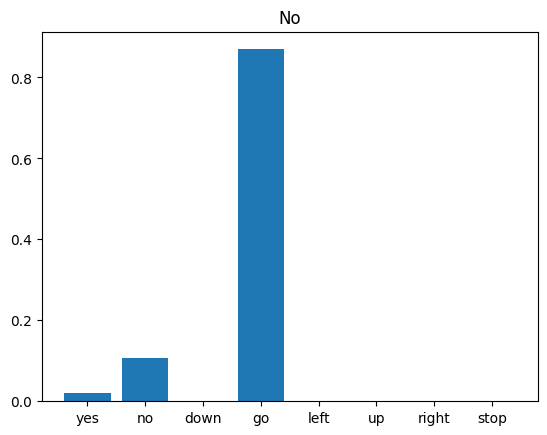

In [44]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['yes', 'no', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))